In [1]:
import pandas as pd
import time
import numpy as np
import struct
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import mapping
from scipy.optimize import curve_fit
import math

Read antpos from xlsx file in repo


In [2]:
#load data
fname = '/data1/cosmic-ray-data/2023May3/overnight1683180610.6110308.dat'
records = parsefile(fname, end_ind = 704*100) #note the first file actually only has 28 events
#make a list of events
events=distinguishevents(records,200)
complete_events_count=0
incomplete_events_count=0
total=len(events)
for e in events:
    if len(e)==704:
        complete_events_count+=1
    else:
        incomplete_events_count+=1
print("Out of ",total," events, there are ",complete_events_count," have exactly 704 records assigned and ", incomplete_events_count, ' events have the wrong number of records.')


Out of  28  events, there are  28  have exactly 704 records assigned and  0  events have the wrong number of records.


In [5]:
## load array map
array_map=pd.read_csv('array-map-5-22-2023.csv')
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

In [18]:
#parameters for antenna-based cuts
maximum_ok_rms=45
minimum_ok_rms=25
minsnr=6

#arrays to store summary info for each event-- right now I look at polarizations separately but maybe could combine
rms_ratioA=np.zeros(len(events))
rms_ratioB=np.zeros(len(events))

n_strong_detectionsA=np.zeros(len(events))
n_strong_detectionsB=np.zeros(len(events))

#go through each event
for i,event_indices in enumerate(events):  
    event=[records[i] for i in event_indices]
    mergedrecords=mergepolarizations(event,arraymapdictionaries)

    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    peakA=np.asarray([record['peakA'] for record in mergedrecords])
    index_peak_A=np.asarray([record['index_peak_A'] for record in mergedrecords])

    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])
    peakB=np.asarray([record['peakB'] for record in mergedrecords])
    index_peak_B=np.asarray([record['index_peak_B'] for record in mergedrecords])
    peak_to_rmsA=peakA/rmsA
    peak_to_rmsB=peakB/rmsB

    #define antenna cut based on rms
    cut_rmsA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cut_rmsB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    #define antenna cut based on peak to rms ratio
    cut_snrA=(peakA/rmsA) >minsnr
    cut_snrB=(peakB/rmsB) >minsnr

    #combine antenna cuts
    total_cutA=np.logical_and(cut_rmsA,cut_snrA)
    total_cutB=np.logical_and(cut_rmsB,cut_snrB)
    
    #calculate summary info
    n_strong_detectionsA[i]=np.sum(total_cutA)
    n_strong_detectionsB[i]=np.sum(total_cutB)
    
    rms_afterA=np.asarray([np.std(record['polA_data'][indexA+10:indexA+60]) for record in mergedrecords]) #could speed it up by only doing rms after event for good antennas
    rms_afterB=np.asarray([np.std(record['polB_data'][indexB+10:indexB+60]) for record in mergedrecords])
    
    if len(rmsA[total_cutA]):
        rms_ratioA[i]=np.median(rms_afterA[total_cutA]/(rmsA[total_cutA]))
    else:
        rms_ratioA[i]=-1
    
    if len(rmsB[total_cutB]):
        rms_ratioB[i]=np.median(rms_afterB[total_cutB]/(rmsB[total_cutB]))
    else:
        rms_ratioB[i]=-1

    

In [34]:
#cut on events based on number of strong detections
minstrongdetections=50
detections_cut=np.logical_or(n_strong_detectionsA>minstrongdetections,n_strong_detectionsB>minstrongdetections)

#cut on events based on rms change and number of strong detections
min_rms_ratio=0.7
max_rms_ratio=1.3
rms_change_cutA=np.logical_and(rms_ratioA>min_rms_ratio,rms_ratioA<max_rms_ratio)
rms_change_cutB=np.logical_and(rms_ratioB>min_rms_ratio,rms_ratioB<max_rms_ratio)
rms_change_cut=np.logical_and(rms_change_cutA,rms_change_cutB)


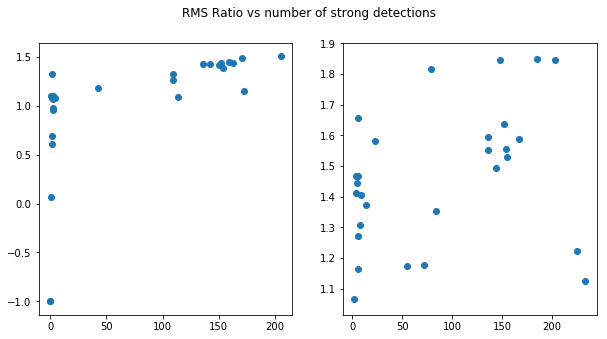

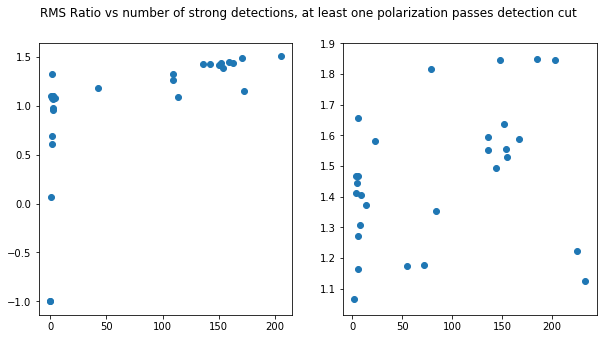

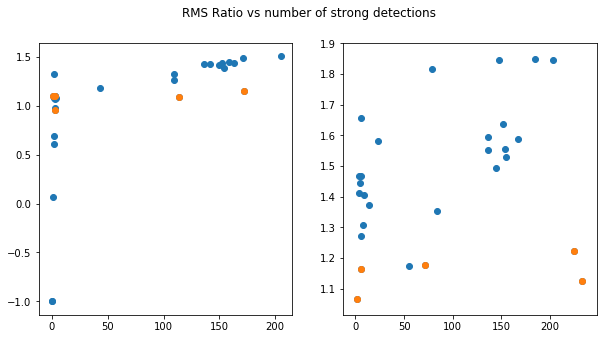

In [36]:
#plt.figure(figsize=(10,5))
#plt.suptitle('Number of strong detections')
#plt.subplot(121)
#plt.hist(n_strong_detectionsA)
#plt.subplot(122)
#plt.hist(n_strong_detectionsB)

#plt.figure(figsize=(10,5))
#plt.suptitle('RMS Ratio')
#plt.subplot(121)
#plt.hist(rms_ratioA,20)
#plt.subplot(122)
#plt.hist(rms_ratioB,20)

plt.figure(figsize=(10,5))
plt.suptitle('RMS Ratio vs number of strong detections')
plt.subplot(121)
plt.scatter(n_strong_detectionsA,rms_ratioA)
plt.subplot(122)
plt.scatter(n_strong_detectionsB,rms_ratioB)

plt.figure(figsize=(10,5))
plt.suptitle('RMS Ratio vs number of strong detections, at least one polarization passes detection cut')
plt.subplot(121)
plt.scatter(n_strong_detectionsA[detections_cut],rms_ratioA[detections_cut])
plt.subplot(122)
plt.scatter(n_strong_detectionsB[detections_cut],rms_ratioB[detections_cut])

plt.figure(figsize=(10,5))
plt.suptitle('RMS Ratio vs number of strong detections')
plt.subplot(121)
plt.scatter(n_strong_detectionsA[detections_cut],rms_ratioA[detections_cut])
plt.scatter(n_strong_detectionsA[np.logical_and(rms_change_cut,detections_cut)],rms_ratioA[np.logical_and(rms_change_cut,detections_cut)])

plt.subplot(122)
plt.scatter(n_strong_detectionsB[detections_cut],rms_ratioB[detections_cut])
plt.scatter(n_strong_detectionsB[np.logical_and(rms_change_cut,detections_cut)],rms_ratioB[np.logical_and(rms_change_cut,detections_cut)])


## Examine interesting events



In [40]:
total_events_cut=np.logical_and(rms_change_cut,detections_cut)
select_events=[events[i] for i in range(len(events)) if total_events_cut[i]]
print(len(select_events))


5


3 233 0.012875536480686695
Not enough polarization A detections to fit


NameError: name 't_rel_B' is not defined

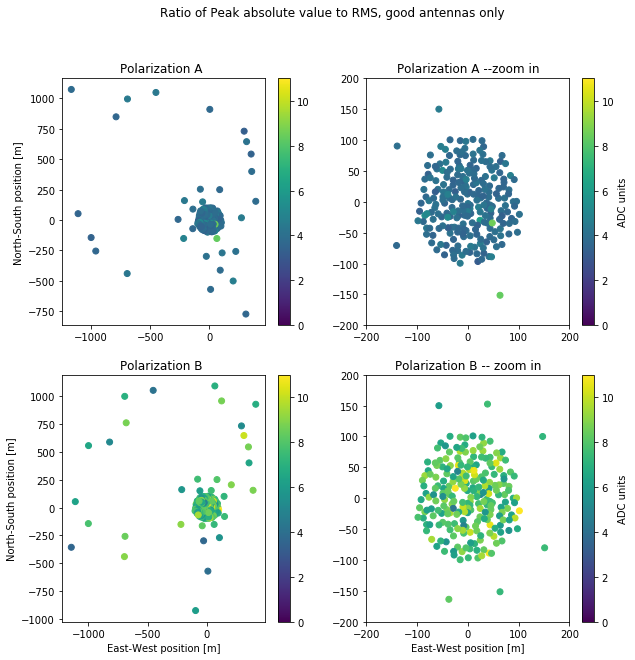

In [41]:

for event_indices in select_events:  
    event=[records[i] for i in event_indices]
    mergedrecords=mergepolarizations(event,arraymapdictionaries)

    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    peakA=np.asarray([record['peakA'] for record in mergedrecords])
    index_peak_A=np.asarray([record['index_peak_A'] for record in mergedrecords])

    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])
    peakB=np.asarray([record['peakB'] for record in mergedrecords])
    index_peak_B=np.asarray([record['index_peak_B'] for record in mergedrecords])
    peak_to_rmsA=peakA/rmsA
    peak_to_rmsB=peakB/rmsB

    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    timestamps=np.asarray([record['timestamp'] for record in mergedrecords])
    min_time=np.min(timestamps)

    #make antenna cut based on rms
    maximum_ok_rms=45
    minimum_ok_rms=25
    cutA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cutB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    cmin=0
    cmax=11
    minsnr=6
    minstrongdetections=20
    plot_peak_to_rms_ratio(peak_to_rmsA,cutA,peak_to_rmsB,cutB,xcoords,ycoords,cmin,cmax)
    strongAdetections=np.sum((peak_to_rmsA[cutA])>minsnr)
    strongBdetections=np.sum((peak_to_rmsB[cutB])>minsnr)
    print(strongAdetections,strongBdetections,strongAdetections/strongBdetections)
    
    #make whole array toa plot too?
    
    #fit direction
    if strongAdetections>minstrongdetections:
        try:
            #direction fit polarization A
            #Make antenna-based cuts on rms, peak-to-rms ratio, and only use core
            #I'm still using the first antenna that passes the cuts as the reference antenna
            cut_snrA=np.logical_and(((peakA/rmsA) >minsnr), (cutA))
            cut_rms_snrA_core=np.logical_and(cut_snrA, (xcoords**2)+(ycoords**2)<(150**2))

            x=xcoords[cut_rms_snrA_core]-xcoords[cut_rms_snrA_core][0]
            y=ycoords[cut_rms_snrA_core]-ycoords[cut_rms_snrA_core][0]
            z=zcoords[cut_rms_snrA_core]-zcoords[cut_rms_snrA_core][0]

            t=t_rel_A[cut_rms_snrA_core]-t_rel_A[cut_rms_snrA_core][0]

            ant_coords=np.zeros((3,len(x)))
            ant_coords[0,:]=x
            ant_coords[1,:]=y
            ant_coords[2,:]=z

            popt, pcov = curve_fit(toa_plane, ant_coords,t,bounds=([0,0],[90,360]),jac=grad_toa_plane)

            print("Polarization A direction best theta, phi ",popt)
            print("Covariance matrix",pcov)
            theta_best=popt[0]
            phi_best=popt[1]

            #plot the results
            best_model_toas=toa_plane(ant_coords,theta_best,phi_best)
            residual=t-best_model_toas
            czoom_min=np.mean(t)-np.std(t)
            czoom_max=np.mean(t)+np.std(t)
            title='Plane wave fit, using only core antennas with peak/rms>'+str(minsnr)
            plot_fit(x,y,t,best_model_toas,residual,czoom_min,czoom_max,title)
        except RuntimeError:
            print("Fit failed with runtime error.")
    else:
        print("Not enough polarization A detections to fit")
    
    if strongBdetections>minstrongdetections:
        #direction fit polarization B
        #Make antenna-based cuts on rms, peak-to-rms ratio, and only use core
        #I'm still using the first antenna that passes the cuts as the reference antenna
        try:
            cut_snrB=np.logical_and(((peakB/rmsB) >minsnr), (cutB))
            cut_rms_snrB_core=np.logical_and(cut_snrB, (xcoords**2)+(ycoords**2)<(150**2))

            x=xcoords[cut_rms_snrB_core]-xcoords[cut_rms_snrB_core][0]
            y=ycoords[cut_rms_snrB_core]-ycoords[cut_rms_snrB_core][0]
            z=zcoords[cut_rms_snrB_core]-zcoords[cut_rms_snrB_core][0]

            t=t_rel_B[cut_rms_snrB_core]-t_rel_B[cut_rms_snrB_core][0]

            ant_coords=np.zeros((3,len(x)))
            ant_coords[0,:]=x
            ant_coords[1,:]=y
            ant_coords[2,:]=z

            popt, pcov = curve_fit(toa_plane, ant_coords,t,bounds=([0,0],[90,360]),jac=grad_toa_plane)

            print("Polarization B direction best theta, phi ",popt)
            print("Covariance matrix",pcov)
            theta_best=popt[0]
            phi_best=popt[1]

            #plot the results
            best_model_toas=toa_plane(ant_coords,theta_best,phi_best)
            residual=t-best_model_toas
            czoom_min=np.mean(t)-np.std(t)
            czoom_max=np.mean(t)+np.std(t)
            title='Plane wave fit, using only core antennas with peak/rms>'+str(minsnr)
            plot_fit(x,y,t,best_model_toas,residual,czoom_min,czoom_max,title)
        except RuntimeError:
            print("Fit failed with RuntimeError")
    
    else:
        print("Not enough polarization B detections to fit")